# "A typical Computer Vision problem: Part 3"
> "In this part, I will be using Deep Learning and specifically Convolutional Neural Networks to tackle this problem and hopefully get better results."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [computer_vision, deep_learning, jupyter, ai]
- image: images/cv-3.jpg
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# Part 3 - Deep Learning with CNNs

In Part 2, I used Random Forests to classify the images. Results were fairly good (**80%+** accuracy) and an F1 score of **0.77**. However, for critical applications such as safety problems, we expect to have better metrics. In this part, I will be using **Deep Learning** and specifically **Convolutional Neural Networks** to tackle this problem and hopefully get better results.

# Checking if GPU is enabled

Deep Neural Networks requires a lot of computation and GPUs have proven to be the best choice for training such networks. This code will check if GPU is enabled so we can continue.

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Uploading Dataset

I'm using **Google Colab** for this and I need to upload the dataset. I will then extract the files to a directory called '**gear_images**'.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving gear_images.zip to gear_images.zip


In [ ]:
import os
os.listdir()

['.config', 'sample_data']

In [ ]:
import zipfile
with zipfile.ZipFile('gear_images.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
os.listdir()

['.config', 'gear_images.zip', 'gear_images', 'sample_data']

# Preparing Features & Labels

I will use OpenCV to deal with images. A helper function called 'resize_to_128' will be used to resize the images. While looping over the images, I will add the corresponding label to the labels 'y'.

In [ ]:
import cv2 as cv

In [ ]:
def resize_to_128(img):
    old_size = img.shape[:2]
    if old_size[0] == old_size[1]:
        img = cv.resize(img,(128, 128))
    else:
        ratio = float(128)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])
        img = cv.resize(img, (new_size[1], new_size[0]))
        delta_w = 128 - new_size[1]
        delta_h = 128 - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        img = cv.copyMakeBorder(img, top, bottom, left, right, cv.BORDER_CONSTANT, value=[255, 255, 255])
    return img

In [ ]:
def prepare_features_labels():
    X = []
    y = []
    directory = os.listdir('gear_images')
    for i, subdir in enumerate(sorted(directory)):
        subdirr = os.path.join('gear_images', subdir)
        for element in sorted(os.listdir(subdirr)):
            filename = os.path.join(subdirr, element)
            X.append(resize_to_128(cv.imread(filename)))
            y.append(i)
        print('Finished '+str(i))
    return X, y

In [ ]:
X, y = prepare_features_labels()

Finished 0
Finished 1
Finished 2
Finished 3
Finished 4
Finished 5
Finished 6
Finished 7
Finished 8
Finished 9
Finished 10
Finished 11


# Starting simple with CNNs

A small model is to be created. It consists of 2 convolutional layers (size 64 and 32 respectively) and a dense layer of size 12 (number of classes). 

1. The activation function for the output is **Softmax**. It transforms the inputs into values between 0 and 1, so that they can be interpreted as probabilities.
2. The optimizer is **Adam**. Adam is different from classical stochastic gradient descent by the fact that Adam doesn't use a single learning rate during training. It also combines **AdaGrad** and **RMSProp** advantages. Adam is being adapted for benchmarks in deep learning papers.
3. The loss function that we're going to optimize is **Categorical Crossentropy** which is used in multi-class classification tasks.

I will be using **Keras** library with **TensorFlow** backend.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=(128,128,3)))
model.add(Conv2D(32, kernel_size=5, activation='relu'))
model.add(Flatten())
model.add(Dense(12, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Normalizing the images for values between 0 and 1

In [ ]:
for i in range(0,len(X)):
    X[i] = X[i]/255

## Splitting between training and test sets

In [ ]:
from sklearn.cross_validation import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X ,y ,test_size = 0.2 ,random_state = 0)

print("Train: ", len(X_train))
print("Test: ", len(X_test))
print("Total: ", len(X_test)+len(X_train))

Train:  1697
Test:  425
Total:  2122


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
import numpy as np
X_train = np.asarray(X_train).reshape(len(X_train),128,128,3)
X_train.shape

(1697, 128, 128, 3)

In [ ]:
X_test = np.asarray(X_test).reshape(len(X_test),128,128,3)


## One-Hot-Encoding of the labels

In [ ]:
from keras.utils import to_categorical
#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape

(1697, 12)

## Training the model

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Train on 1697 samples, validate on 425 samples
Epoch 1/5
1697/1697 [==============================] - 11s 6ms/step - loss: 2.0256 - acc: 0.5203 - val_loss: 0.8557 - val_acc: 0.7365
Epoch 2/5
1697/1697 [==============================] - 7s 4ms/step - loss: 0.4844 - acc: 0.8438 - val_loss: 0.4485 - val_acc: 0.8729
Epoch 3/5
1697/1697 [==============================] - 7s 4ms/step - loss: 0.1147 - acc: 0.9582 - val_loss: 0.5307 - val_acc: 0.8612
Epoch 4/5
1697/1697 [==============================] - 7s 4ms/step - loss: 0.0549 - acc: 0.9859 - val_loss: 0.5216 - val_acc: 0.8682
Epoch 5/5
1697/1697 [==============================] - 7s 4ms/step - loss: 0.0602 - acc: 0.9853 - val_loss: 1.0991 - val_acc: 0.7953


## Plotting the model accuracy and loss

In order to know how the training is evolving, I will use the output of the training (the **history** variable) to plot the model accuracy and loss.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


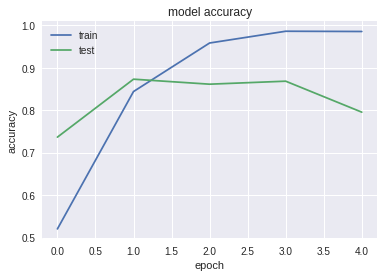

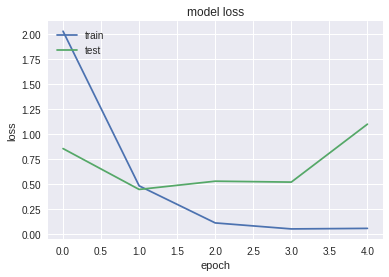

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Improving the CNNs: Max Pooling

After each convolutional layer, I will add a **Max Pooling** layer with filter size (2, 2).

The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its **dimensionality** and allowing for **assumptions** to be made about features contained in the sub-regions binned.

In [ ]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(12, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Train on 1697 samples, validate on 425 samples
Epoch 1/5
1697/1697 [==============================] - 3s 2ms/step - loss: 1.1776 - acc: 0.6193 - val_loss: 0.5745 - val_acc: 0.8353
Epoch 2/5
1697/1697 [==============================] - 3s 2ms/step - loss: 0.4062 - acc: 0.8662 - val_loss: 0.5385 - val_acc: 0.7882
Epoch 3/5
1697/1697 [==============================] - 3s 1ms/step - loss: 0.1704 - acc: 0.9393 - val_loss: 0.2932 - val_acc: 0.9200
Epoch 4/5
1697/1697 [==============================] - 3s 1ms/step - loss: 0.0872 - acc: 0.9741 - val_loss: 0.2998 - val_acc: 0.9294
Epoch 5/5
1697/1697 [==============================] - 3s 1ms/step - loss: 0.0647 - acc: 0.9770 - val_loss: 0.4388 - val_acc: 0.8729


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


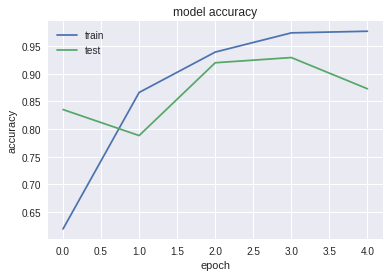

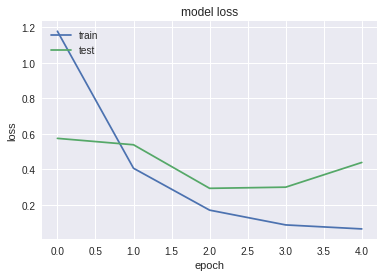

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_eval = model.evaluate(X_test, y_test, verbose=0)


In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.43881059031823977
Test accuracy: 0.8729411764705882


**Accuracy of 87.29%, getting close to 90%.**

# Improving the CNNs: Regularization

**Regularization** is a widely used technique to prevent **overfitting**. Large neural networks trained on relatively small datasets can overfit the training data. This will have a bad effect on **generalization** (when we predict the class for unseen data). For that, I'll perform regularization by adding two dropout layers of 0.35 and 0.25. During training, some number of layer outputs are **randomly** ignored or "**dropped out**". This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer.

In [ ]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.35))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(12, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Train on 1697 samples, validate on 425 samples
Epoch 1/5
1697/1697 [==============================] - 3s 2ms/step - loss: 1.6973 - acc: 0.4520 - val_loss: 0.7383 - val_acc: 0.7482
Epoch 2/5
1697/1697 [==============================] - 3s 2ms/step - loss: 0.5445 - acc: 0.8150 - val_loss: 0.5098 - val_acc: 0.8541
Epoch 3/5
1697/1697 [==============================] - 3s 2ms/step - loss: 0.3301 - acc: 0.8804 - val_loss: 0.3717 - val_acc: 0.8824
Epoch 4/5
1697/1697 [==============================] - 3s 2ms/step - loss: 0.1986 - acc: 0.9352 - val_loss: 0.3184 - val_acc: 0.8965
Epoch 5/5
1697/1697 [==============================] - 3s 2ms/step - loss: 0.1363 - acc: 0.9517 - val_loss: 0.2792 - val_acc: 0.9176


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


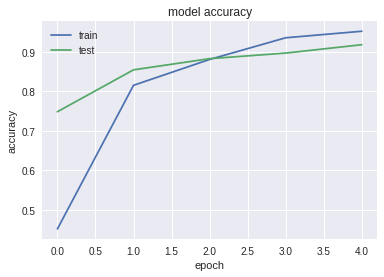

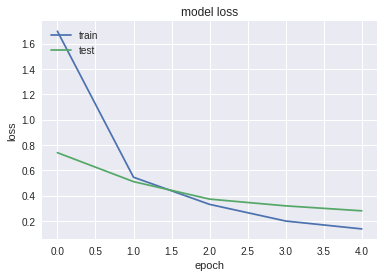

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_eval = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.2792251286261222
Test accuracy: 0.9176470588235294


**Reaching an accuracy of 91.7%**

In [ ]:
uploaded = files.upload()

Saving newdata.zip to newdata.zip


In [ ]:
with zipfile.ZipFile('newdata.zip', 'r') as zip_ref:
    zip_ref.extractall()

## Data from the real world

The data that we used so far comes from one provider. In the real world, images might be different therefore it's always best to test the model on some data that is totally independant from the data that we have. For this reason, I searched for 5 images and put them in the directory 'newdata'. I will predict the classes and check the accuracy.

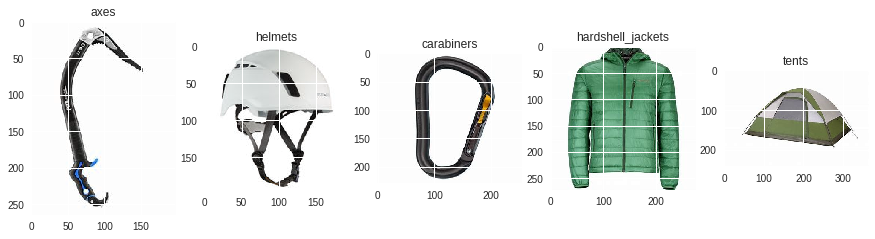

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15,15))
class_names = ['axes','boots','carabiners','crampons','gloves','hardshell_jackets','harnesses','helmets','insulated_jackets','pulleys','rope','tents']
for i, image in enumerate(os.listdir('newdata')):
    im = resize_to_128(cv.imread('newdata/'+image))/255
    pred = model.predict(im.reshape(1,128,128,3))
    name = class_names[np.argmax(pred, axis=1)[0]]
    axes[i].imshow(cv.imread('newdata/'+image))
    axes[i].set_title(name)

The hardhsell_jackets is a wrong prediction. It's an insulated jacket. So we have an accuracy of 80%.

# Transfer Learning with VGG16

**Transfer Learning** is a popular technique used in computer vision and other problems as well. It consists of using **pre-trained** networks that were trained on large datasets to solve our problems. Keras provides us with top pre-trained networks. 

This technique also includes **fine-tuning** the network to solve our problem.

I will now try transfer learning with VGG16 pre-trained model with imagenet dataset. I will start by showing a summary of the model.

In [ ]:
from keras.applications import VGG16
 
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

## Fine Tuning: Freezing some layers

The final model consists of the top of the **VGG16** model and two dense layers along with a dropout layer for regularization. I froze all the layers of the initial network but the last 4 so only the last 4 will get to be trained again.

In [ ]:
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

finalmodel = Sequential()
 
# Add the vgg convolutional base model
finalmodel.add(vgg_model)
 
# Add new layers
finalmodel.add(Flatten())
finalmodel.add(Dense(1024, activation='relu'))
finalmodel.add(Dropout(0.5))
finalmodel.add(Dense(12, activation='softmax'))
 
finalmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 12)                12300     
Total params: 23,116,620
Trainable params: 15,481,356
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
finalmodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
history = finalmodel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Train on 1697 samples, validate on 425 samples
Epoch 1/10
1697/1697 [==============================] - 10s 6ms/step - loss: 0.4079 - acc: 0.8792 - val_loss: 0.5433 - val_acc: 0.8918
Epoch 2/10
1697/1697 [==============================] - 8s 5ms/step - loss: 0.0786 - acc: 0.9729 - val_loss: 0.1029 - val_acc: 0.9694
Epoch 3/10
1697/1697 [==============================] - 8s 5ms/step - loss: 0.0364 - acc: 0.9882 - val_loss: 0.0453 - val_acc: 0.9882
Epoch 4/10
1697/1697 [==============================] - 8s 5ms/step - loss: 0.0423 - acc: 0.9894 - val_loss: 0.0880 - val_acc: 0.9647
Epoch 5/10
1697/1697 [==============================] - 8s 5ms/step - loss: 0.0422 - acc: 0.9918 - val_loss: 0.0654 - val_acc: 0.9788
Epoch 6/10
1697/1697 [==============================] - 8s 5ms/step - loss: 0.0307 - acc: 0.9923 - val_loss: 0.0685 - val_acc: 0.9835
Epoch 7/10
1697/1697 [==============================] - 8s 5ms/step - loss: 0.0156 - acc: 0.9965 - val_loss: 0.0590 - val_acc: 0.9859
Epoch 8/10
169

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


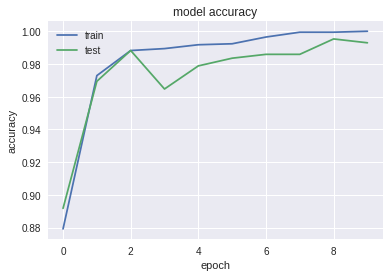

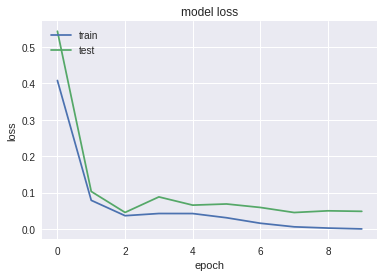

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_eval = finalmodel.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.04831699640243297
Test accuracy: 0.9929411764705882


**With the new model, we were able to reach an accuracy of 99.29%!**

## Data from the real world

Using the images uploaded earlier to the directory 'newdata'. I will predict the classes and check the accuracy.

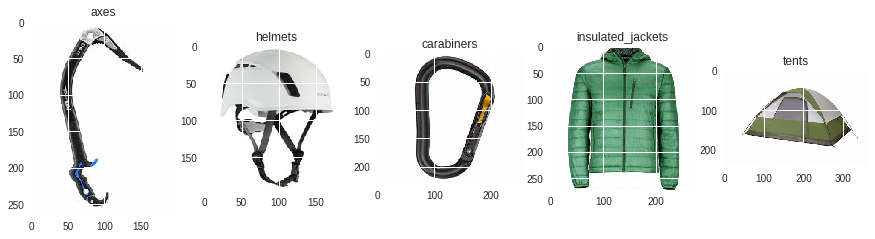

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15,15))
class_names = ['axes','boots','carabiners','crampons','gloves','hardshell_jackets','harnesses','helmets','insulated_jackets','pulleys','rope','tents']
for i, image in enumerate(os.listdir('newdata')):
    im = resize_to_128(cv.imread('newdata/'+image))/255
    pred = finalmodel.predict(im.reshape(1,128,128,3))
    name = class_names[np.argmax(pred, axis=1)[0]]
    axes[i].imshow(cv.imread('newdata/'+image))
    axes[i].set_title(name)

**All the predictions are correct! Accuracy of 100% on the test data.**

# Conclusion

This series consisted of three parts:
1. Exploring the Data, Plotting and Resizing.
2. Using Simple Statistical Machine Learning.
3. Achieving Higher Accuracy with Convolutional Neural Networks.

I was able to show how to tackle a typical **computer vision** problem, when to use simple **Machine Learning** and when to use **Deep Learning**. I also showed how to improve **CNNs** models by starting simple then adding more layers as we go. Lastly, I showed how to perform **Transfer Learning** to achieve better results.